#  RAG Example (small but complete)

- (saved) Vector DB (Chroma)
- Ollama

In [ ]:
#from langchain_community.vectorstores import Chroma
from langchain_chroma import Chroma
from langchain_huggingface.embeddings import HuggingFaceEmbeddings

## Specify embedding model and vector store

In [ ]:
embedding_model = HuggingFaceEmbeddings()
database_loc = ("./chroma_db_test1")

vectorstore = Chroma(persist_directory=database_loc,
      embedding_function=embedding_model)
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 8})

## Specify the LLM

We are going to use Ollama to keep it simple

In [ ]:
from langchain_ollama import OllamaLLM
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

llm = OllamaLLM(model='llama3.1:8b') 

## Create a simple prompt template

This can be handled in many ways and can be very simple to complex.

In [ ]:
from langchain_core.prompts import PromptTemplate

template = """You are an AI counselor. Answer questions using the provided information. 
Make sure to cover as much information as possible.
{context}
Question: {question}

Answer:"""

prompt = PromptTemplate.from_template(template)

## Create a chain of steps

In [ ]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document

# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    retrieved_docs = vectorstore.similarity_search(state["question"])
    return {"context": retrieved_docs}

def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    #print(docs_content)
    #print(response)
    #return {"answer": response.content}
    return {"answer": response}

## Connect them and save them as a Langgraph

This is quite new. Chain creation was done thorugh piping until recently.

In [18]:
from langgraph.graph import START, StateGraph

# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

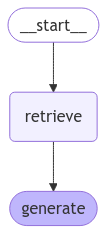

In [26]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## Now comes the fun part!

In [25]:
response = graph.invoke({"question": "Are there Japanese classes offered at Lafayette?"})

print(f'Answer: {response["answer"]}\n\n')
print("*" *80)      
print(f'Context: {response["context"]}\n\n')

Answer: Yes, there are Japanese classes offered at Lafayette. Specifically, you can take Adv Japanese 1, Adv Japanese 2, Adv Japanese 3, and AP Japanese Language & Culture as elective courses. These classes cover various aspects of the Japanese language, including listening, speaking, reading, writing, and cultural studies.

To provide more details:

* Adv Japanese 1 covers basic listening, speaking, reading, and writing skills, with an introduction to Japanese culture and career opportunities.
* Adv Japanese 2 builds on the previous course, focusing on improving listening, speaking, reading, and writing skills, as well as introducing famous Japanese people and popular topics.
* Adv Japanese 3 emphasizes accurate and resourceful expression in both oral and written communication, with a fast-paced class environment.
* AP Japanese Language & Culture explores social, political, religious, and educational issues, traditional versus modern gender roles, and the application of language skill

In [24]:
response = graph.invoke({"question": "What is SCAPA at Lafayette?"})

print(f'Answer: {response["answer"]}\n\n')
print("*" *80)      
print(f'Context: {response["context"]}\n\n')

Answer: SCAPA (School for the Creative and Performing Arts) at Lafayette is a program that provides students who are gifted or talented in the arts with the opportunity to further develop and enhance their abilities in the fine arts. The program focuses on both arts and academics, offering students a unique experience.

At SCAPA at Lafayette, students take two classes per year in their designated area of arts specialization, such as ballet, contemporary dance, theatre, technical theatre, literary arts, music (band, strings, keyboard or voice), or visual arts. Arts area instruction is provided by specialized instructors.

Additionally, SCAPA offers students access to master classes, exhibits, lectures, and other off-campus experiences throughout the year. To be admitted to SCAPA at Lafayette, students must apply and successfully audition through the FCPS (Fayette County Public Schools) gifted and talented visual & performing arts identification process.

The program also allows for Opti